In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
from extraction_sm import *

In [43]:
# let's process multiple files at once - I want some nicer statistic
# this is a time-ordered file of filenames for SM1 or SM2

#pathfile = "../filenames_sm1.txt"
pathfile = "../filenames_sm2.txt"

allfiles = []
f = open(pathfile, 'r')
allfiles = f.readlines()
f.close()

# strip away newlines and add absolute path prefix
allfiles = ["../../"+s.strip() for s in allfiles]


# select a few files - say some random date(s)
mydates = ["2017-06-30","2017-07-01","2017-07-02","2017-07-03","2017-07-04"]
#mydates = ["2017-06-30"]
#mydates = ["2017-09-11"]

sourcefiles = []

for date in mydates:
    sourcefiles += [s for s in allfiles if date in s]

#sourcefiles = [sourcefiles[0]]  # if I want to use only one files

print("Using", len(sourcefiles), "files")

Using 21 files


In [44]:
out = []  # where our output will go

# let's test the execution time
import time
timingstart = time.time()


for sourcefile in sourcefiles:
    (image,gain,bias,readnoise,fov,row,tstart,tstop) = sm_get_image(sourcefile, "../../datasets/sm_bias/sm_calibdat.fits")

    starmask = sm_starmask(image, 2000)


    output = sm_cosmics(image, gain, bias, readnoise, starmask, sigclip=10., sigfrac=0.3, objlim=10.)
    output['acqTime'] = tstart
    output['dT'] = tstop - tstart
    
    out.append(output)


timingend = time.time()
print("Elapsed time:", timingend - timingstart)

/home/ckirsch/git/cosmics/analysis/sm_sif/extraction_sm.py:233: RuntimeWarning: invalid value encountered in sqrt
  err_mean = np.sqrt(var_mean + readnoise*readnoise + gain*imbias)              # total error
/home/ckirsch/git/cosmics/analysis/sm_sif/extraction_sm.py:233: RuntimeWarning: invalid value encountered in sqrt
  err_mean = np.sqrt(var_mean + readnoise*readnoise + gain*imbias)              # total error


Elapsed time: 62.854024171829224


# Some diagnostics

In [45]:
# Do some statistics

Etot = []

# also for lengths, why not
AL = []
AC = []


for ii in range(len(out)):
    for jj in range(len(out[ii]["Etot"])):
        Etot.append(out[ii]["Etot"][jj])
        (dimL,dimC) = (out[ii]["cosmics"][jj]).shape
        AL.append(dimL-1)
        AC.append(dimC-1)


Etot = np.array(Etot)
AL = np.array(AL)
AC = np.array(AC)


        
# number of cosmics
print(len(Etot), "cosmics")


7227 cosmics


Energies

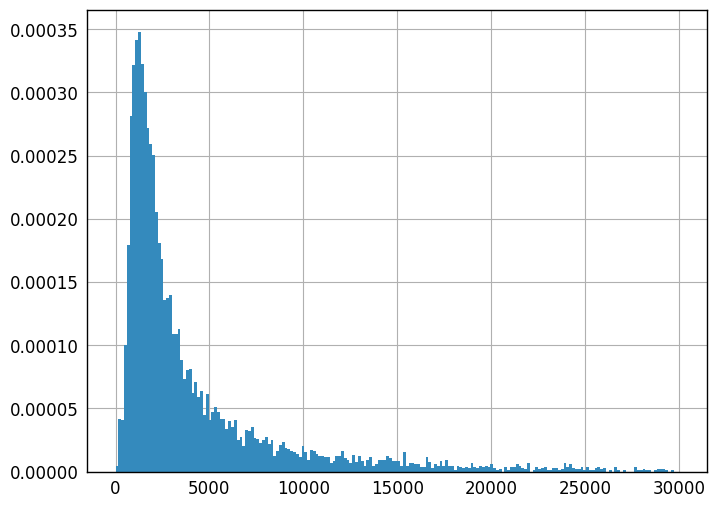

In [46]:
histE = plt.hist(Etot, 200, log=False ,range=(0,30000), normed=True)

Lengths and angles

In [47]:
# Let's try the angles
# For now without how it faces

lx = AL*20  # mum
ly = AC*60 # mum

theta = np.zeros(lx.shape)

nonzero = np.logical_and(lx!=0, ly!=0)
theta[nonzero] = np.arctan(ly[nonzero]/lx[nonzero])*180/np.pi

theta[lx==0] = 5000  # 90
theta[ly==0] = 5000  # 0
theta[np.logical_and(lx==0, ly==0)] = 5000  # ignore for now

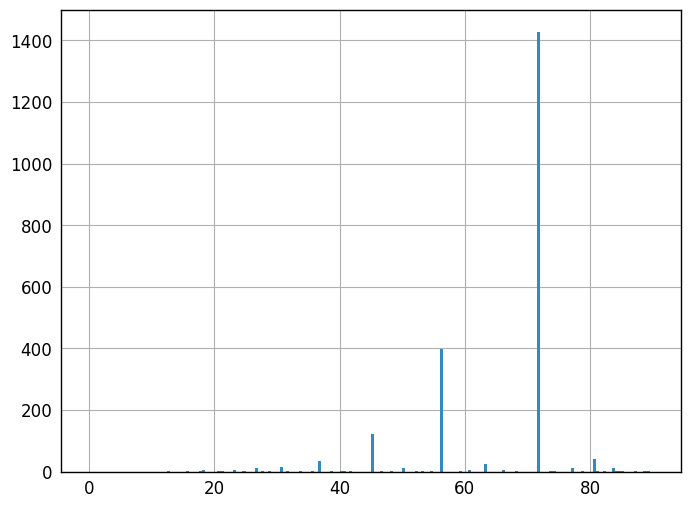

In [48]:
thist = plt.hist(theta,180,range=(0,90))

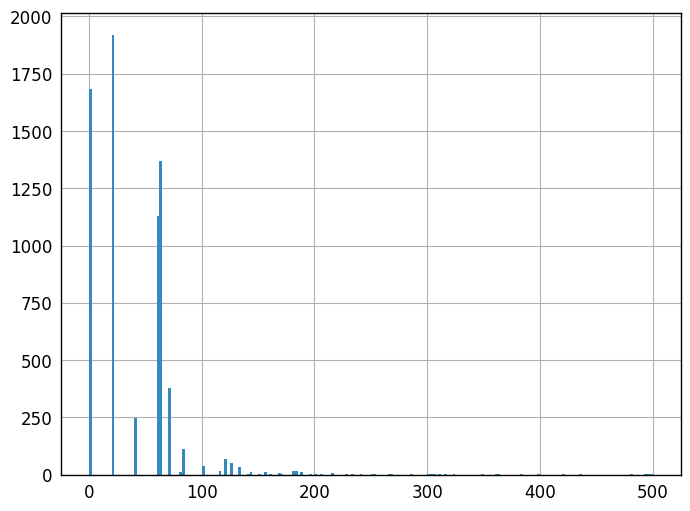

In [49]:
lengths = np.sqrt(lx*lx + ly*ly)

lhist = plt.hist(lengths,200,range=(0,500),log=False)

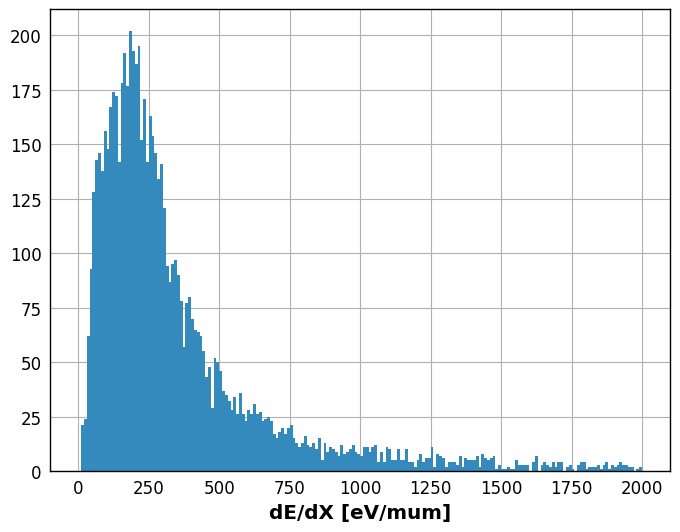

In [50]:
dEdx = Etot/np.sqrt(lengths**2+16**2) # assuming our length measurement is good and we excite the whole detector

dEdx *= 3.6   # energy (eV) per electron/hole pair

thist = plt.hist(dEdx,200,log=False,range=(0,2000))
plt.xlabel("dE/dX [eV/mum]")

Weird thing: In a flare, this actually has the same maximum - although higher counts, especially where this one flattens off.

In [51]:
acqTimes = []

for ii in range(len(out)):
    acqTimes.append(out[ii]['acqTime'])
    
acqTimes = np.array(acqTimes)

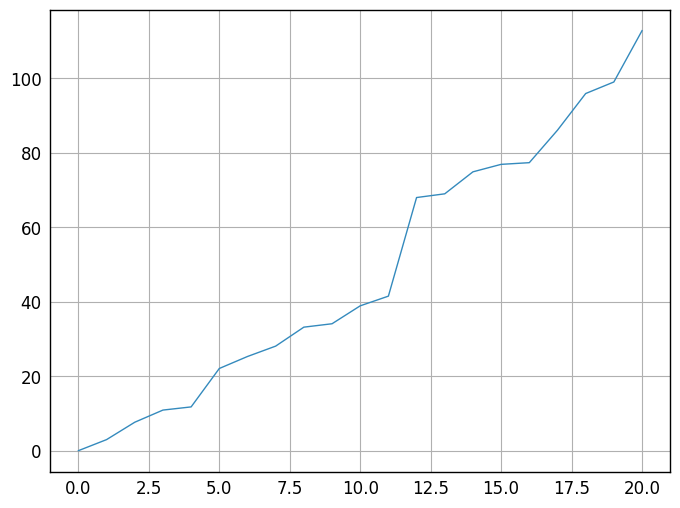

In [52]:
plt.plot((acqTimes - acqTimes[0])/1e9/3600)